In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
%matplotlib inline

## ISBI12

Источник: https://www.kaggle.com/datasets/soumikrakshit/isbi-challenge-dataset

Содержит 30 изображений(512х512) брюшной нервной цепи личинки дрозофилы, 
полученных с помощью просвечивающего электронного микроскопа. 
Изобажения представляют из себя последовательные срезы.
Датасет содержит 3 volume: train-volume, train-labels, test-volume.
В данном ноутбуке обрабатываются изображения из train-labels для подготовки датасета модели.

isbi12_data.hdf5:

    original - исходный датасет 30х512х512

    augmented/tile/128 - количество изображений исходного датасета увеличено в 8 раз поворотами и отражениями, после этого каждое изображение было поделено на (512/128)^2=16 непересекающихся частей

    augmented/random/128 - количество изображений исходного датасета увеличено в 8 раз поворотами и отражениями, после этого из каждого изображения произвольным образом выбирались 16 областей указанного размера и включались в датасет

In [9]:
images_path = '../data/isbi12/'
image_names = [image_name for image_name in os.listdir(path=images_path) if image_name.endswith('.jpg')]

images = np.zeros((30, 512, 512))

for index, image_name in enumerate(image_names):
    images[index] = cv2.imread(images_path+image_name, cv2.IMREAD_GRAYSCALE)

In [10]:
def flip_rotate(data, flip=True, rotate=True):
    result = np.zeros((data.shape[0]*8, data.shape[1], data.shape[2]))
    n = data.shape[0]
    result[0:n] = data
    result[n:n*2] = np.rot90(data, 1, (1,2))
    result[n*2:n*3] = np.rot90(data, 2, (1,2))
    result[n*3:n*4] = np.rot90(data, 3, (1,2))
    result[n*4:n*5] = np.flip(data, axis=2)
    result[n*5:n*6] = np.rot90(np.flip(data, axis=2), 1, (1, 2))
    result[n*6:n*7] = np.rot90(np.flip(data, axis=2), 2, (1, 2))
    result[n*7:n*8] = np.rot90(np.flip(data, axis=2), 3, (1, 2))
    return result

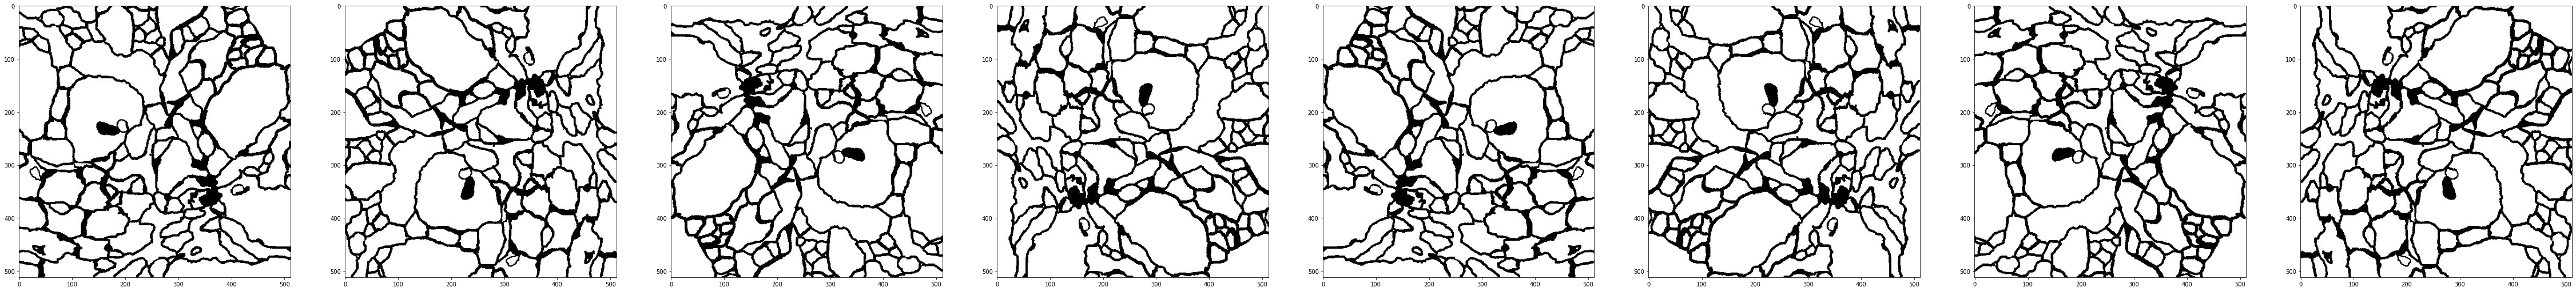

In [11]:
result = flip_rotate(images)
fig, axes = plt.subplots(1, 8, figsize=(80,10))
for i in range(8):
    axes[i].imshow(result[i*30,:,:].squeeze(), cmap="gray")

In [12]:
def augmentation_without_intersection(data, coef):
    side = data.shape[1]//coef
    number = coef**2
    n = data.shape[0]
    result = np.zeros((n*number, side, side))
    for i in range(coef):
        for j in range(coef):
            result[(i*coef+j)*n:(i*coef+j+1)*n] = data[:, i*side:(i+1)*side, j*side:(j+1)*side]
    return result

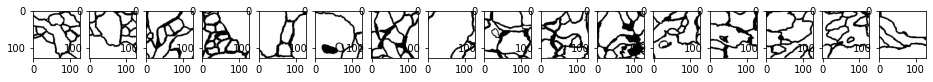

In [13]:
images_aug_tile = augmentation_without_intersection(flip_rotate(images), 4)
fig, axes = plt.subplots(1, 16, figsize=(16,1))
for i in range(16):
    axes[i].imshow(images_aug_tile[i*30*8,:,:].squeeze(), cmap="gray")

In [14]:
def augmentation_random(data, side, number):
    data_side = data.shape[1]
    n = data.shape[0]
    result = np.zeros((n*number, side, side))
    for i in range(n):
        for j in range(number):
            x, y = np.random.randint(0, data_side-side, 2)
            result[i*number+j] = data[i, x:x+side, y:y+side]
    return result

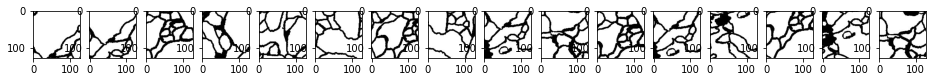

In [15]:
images_aug_random = augmentation_random(flip_rotate(images), 128, 16)
fig, axes = plt.subplots(1, 16, figsize=(16,1))
for i in range(16):
    axes[i].imshow(images_aug_random[i,:,:].squeeze(), cmap="gray")

In [16]:
p = 0.8
with h5py.File('isbi12_data.hdf5', 'w') as f:
    tile = f.create_group('augmented/tile')
    aug_tile_original = tile.create_dataset('128', data=images_aug_tile)
    np.random.shuffle(images_aug_tile)
    n = images_aug_tile.shape[0]
    train_size = int(n*p)
    aug_tile_train = tile.create_dataset('train', data=images_aug_tile[0:train_size])
    aug_tile_test = tile.create_dataset('test', data=images_aug_tile[train_size:])
    
    random = f.create_group('augmented/random')
    aug_random_original = random.create_dataset('128', data=images_aug_random)
    np.random.shuffle(images_aug_random)
    n = images_aug_random.shape[0]
    train_size = int(n*p)
    aug_random_train = random.create_dataset('train', data=images_aug_random[0:train_size])
    aug_random_test = random.create_dataset('test', data=images_aug_random[train_size:])
    
    dset = f.create_dataset('original', data=images)

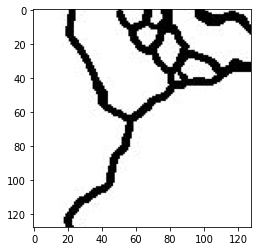

In [17]:
with h5py.File('isbi12_data.hdf5', 'r') as f:
    dset = f['augmented/tile/train'][:]
plt.imshow(dset[0], cmap='gray')